<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/retraining_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 297 (delta 97), reused 66 (delta 37), pack-reused 145
Receiving objects: 100% (297/297), 45.55 MiB | 26.88 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


# Baseline to show the effect of catastrophic forgetting 

In this section, On the pre-trained network, we will continuously train novel classes.We observe that training new tasks significantly lowers the performance of the old class. This phenomenon is referred to as catestropic forgetting.


Experiment:

1. We will take pre-trained network.
2. Pre-process new task data.
3. train netwrok on new task individually and calculate old class accuracy.
4. plot the old class performance in terms of accuracy after training for each novel class.

Observation:

The plot below shows a decline in old class performance. This decline in accuracy is due to catestropic forggeting. The network continually forgets parameters related to previous data when attempting to learn from new data. As a result, the internetnetwrok forgets previously learned information.


In [2]:
import torch
import torch.nn as nn
import os
import copy
import torch.nn.functional as F
import torchaudio
import models
from torch.utils.data import DataLoader,random_split,Dataset
# from torch.optim import lr_scheduler
import torchvision
from utils import label_to_index, index_to_label, get_average_of_list
import utils
from dataset import SubsetSC
# import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
# from datetime import datetime

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

In [4]:
torch.cuda.is_available()

True

# Data Processing

In [5]:
#list of novel class targets that we'd use for further training 
random_targets = ['follow']

traindata = SubsetSC("training", "novel", novel_class_list= random_targets)
testdata = SubsetSC("testing", "novel", novel_class_list= random_targets)

#for classification labels would be combination of novel classes and old classes(digits)
targets_list = [os.path.basename(os.path.dirname(traindata._walker[i])) for i in range(len(traindata))]
novel_targets = list(set(targets_list))
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
total_targets_list = digits + novel_targets 

#create index list of total target to later use in training data analysis
novel_targets_list_indices = []
for i in novel_targets:
        novel_targets_list_indices.append(label_to_index(total_targets_list, i).item())

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(total_targets_list, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets

novel_train_dataloader = DataLoader(traindata,batch_size=20, collate_fn=collate_fn, shuffle=True)
novel_test_dataloader = DataLoader(testdata, batch_size = 20, collate_fn=collate_fn, shuffle=True)

old_testdata = SubsetSC("testing", "old")
old_test_dataloader = DataLoader(old_testdata,batch_size=20, collate_fn=collate_fn, shuffle=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [6]:
from statistics import mean

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def get_convnet(convnet_type):
    name = convnet_type.lower()
    if name == "vgg":
      FILE_PATH = "./savedmodels/vgg_checkpoint.pth"
      print("getting VGG pre-trained model")
      vgg_model = models.VGGNet()
      vgg_model.load_state_dict(copy.deepcopy(torch.load(FILE_PATH, map_location='cpu')), strict=False)
      return vgg_model
    elif name == "alexnet":
      FILE_PATH = "./savedmodels/checkpoint_alexnet.pth"
      print("getting AlexNet pre-trained model")
      alexnet_model = models.AlexNet()
      alexnet_model.load_state_dict(copy.deepcopy(torch.load(FILE_PATH, map_location='cpu')), strict=False)
      return alexnet_model


def calculate_accuracy(dataloader, model):
  #Accuracy for given test data
  model.to(device)
  with torch.no_grad():
    class_acc =[]
    model.eval()
    for i, (inputs, labels) in enumerate(dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      logits = model(inputs)
      loss = F.cross_entropy(logits, labels)
      _, pred = logits.max(1)
      acc = (pred == labels).sum().item() / pred.size(0)
      class_acc.append(acc)
  return mean(class_acc), loss.item()

# Training method

In [9]:
def train(train_dataloader, test_dataloader, old_test_dataloader, optimizer, model, num_epochs, log = []):
  #traing pipeline
  for epoch in range(num_epochs):
    running_loss = []
    running_accuracy = []
    model.to(device)
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      logits = model(inputs) #batch_size x 14
      loss = F.cross_entropy(logits, labels)
      optimizer.zero_grad()
      loss.backward() 
      optimizer.step()
      running_loss.append(loss.item())
      _, pred = logits.max(1)
      acc = (pred == labels).sum().item() / pred.size(0)
      running_accuracy.append(acc)
    train_loss = mean(running_loss)
    train_accuracy = mean(running_accuracy)
    test_accuracy , test_loss = calculate_accuracy(dataloader=test_dataloader, model=model)
    old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
    print(f"Epoch [{epoch}]... train_loss: {train_loss}, train_acc: {train_accuracy}")
    print(f"\t     val_loss: {test_loss}, val_acc: {test_accuracy}")
    print(f"\t     old_loss: {old_class_loss}, old_acc: {old_class_accuracy}")
    log.append({
    'epoch': epoch,
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': test_loss,
    'val_accuracy': test_accuracy,
    'old_class_loss' : old_class_loss,
    'old_class_accuracy': old_class_accuracy
    })
  return

In [10]:
import numpy as np

In [11]:
def _incremental_model(model, _no_out_features: int = 0):
  #this function increase nodes in the last layer to learn new task
  in_features = model.linear.in_features
  out_features = model.linear.out_features
  #everytime increment class with one new class
  incremental_model_linear = nn.Linear(in_features=in_features, out_features=1)
  incremental_model_linear.to(device)
  model.to(device)

  nn.init.constant_(incremental_model_linear.bias, 0)

  old_weights = copy.deepcopy(model.linear.weight.data)
  old_bias = copy.deepcopy(model.linear.bias.data)
  incremental_model_linear_weights = copy.deepcopy(incremental_model_linear.weight.data)
  incremental_model_linear_bias = copy.deepcopy(incremental_model_linear.bias.data)
  model.linear = nn.Linear(in_features=in_features, out_features=_no_out_features)
  
  new_weights = torch.cat([old_weights, incremental_model_linear_weights], dim=0)
  new_bias = torch.cat([old_bias, incremental_model_linear_bias] ,dim=0)
  model.linear.weight.data = new_weights
  model.linear.bias.data = new_bias

  return model

#Continous learning for new tasks

In [22]:
learning_rate = 0.001
num_epochs = 3 #we will train only for few epoch because it decreases accuracy rapidly
log = []
_network = 'vgg'

# #Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model
print("Loading the pre-trained model...")
model = get_convnet("vgg")

# save old accuracy before increment to know the old class performance beforehand
old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
log.append({
  'epoch': -1,
  'train_loss': np.nan,
  'train_accuracy': 0,
  'val_loss': np.nan,
  'val_accuracy': 0,
  'old_class_loss' : old_class_loss,
  'old_class_accuracy': old_class_accuracy
  })


Loading the pre-trained model...
getting VGG pre-trained model


In [23]:
#list of new task  to be learn
multiclass_learning = ["follow", "marvin", "visual", "house", "happy"]
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
new_targets_list = digits
#loop to take data individually for new tasks list and train 
for _class_name in multiclass_learning:
  print(f"Training for {_class_name}")
  
  #process data for _class_name
  traindata = SubsetSC("training", "novel", novel_class_list= [_class_name], dataset_length= 100)
  testdata = SubsetSC("testing", "novel", novel_class_list= [_class_name], dataset_length=20)
  new_targets_list += [_class_name]
  def collate_fn(batch):
          tensors, targets = [], []
          for waveform, label in batch:
                  tensors += [torch.squeeze(waveform)]
                  targets += [label_to_index(new_targets_list, label)]
          tensors = torch.unsqueeze(pad_sequence(tensors), 1)
          targets = torch.stack(targets)
          return tensors, targets
  new_novel_train_dataloader = DataLoader(traindata,batch_size=20, collate_fn=collate_fn, shuffle=True)
  new_novel_test_dataloader = DataLoader(testdata, batch_size = 10, collate_fn=collate_fn, shuffle=True)

  #increse last nodes in multiclass
  model = _incremental_model(model, _no_out_features = len(new_targets_list))
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  #train for current _class_name
  train(new_novel_train_dataloader, 
        new_novel_test_dataloader, 
        old_test_dataloader, 
        optimizer,
        model, 
        num_epochs, 
        log)

Training for follow
Epoch [0]... train_loss: 0.5379878997802734, train_acc: 0.92
	     val_loss: 0.23387034237384796, val_acc: 0.95
	     old_loss: 19.15304946899414, old_acc: 0.6268377253814147
Epoch [1]... train_loss: 0.06400499138040913, train_acc: 0.98
	     val_loss: 0.2037000209093094, val_acc: 0.95
	     old_loss: 23.269834518432617, old_acc: 0.6244105409153953
Epoch [2]... train_loss: 0.653453355308784, train_acc: 0.97
	     val_loss: 8.792896551312879e-05, val_acc: 0.95
	     old_loss: 10.340228080749512, old_acc: 0.561754507628294
Training for marvin
Epoch [0]... train_loss: 1.8403638660907746, train_acc: 0.76
	     val_loss: 4.585028171539307, val_acc: 0.45
	     old_loss: 2.5059895515441895, old_acc: 0.4615117891816921
Epoch [1]... train_loss: 0.5814764380455018, train_acc: 0.89
	     val_loss: 1.4005482196807861, val_acc: 0.55
	     old_loss: 5.834730625152588, old_acc: 0.37486130374479887
Epoch [2]... train_loss: 0.3363437280058861, train_acc: 0.89
	     val_loss: 0.97333

In [24]:
#Plot log data for old class acuuracy
df_log = pd.DataFrame(log)

In [27]:
#save data  to further compare with other algorithms
df_log.to_pickle("retraining_baseline.pkl")

In [48]:
plt.rcParams["figure.figsize"] = [8, 8]

#plot old class performance against task learned

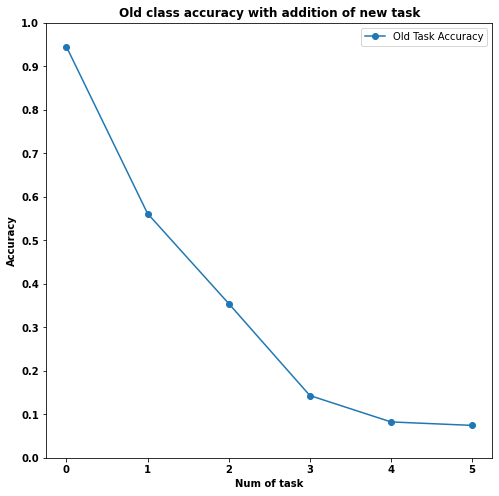

In [55]:
fig = plt.figure()
old_class_acc = df_log[['old_class_accuracy']][::num_epochs]
task_number = np.arange(len(old_class_acc))
plt.plot(task_number,old_class_acc, label= "Old Task Accuracy", marker = 'o')
plt.xlabel("Num of task", weight = 'bold')
plt.ylabel("Accuracy", weight = 'bold')
plt.xticks(weight='bold')
plt.yticks(np.arange(0,1.1,0.1),weight='bold')
plt.title("Old class accuracy with addition of new task", weight = 'bold')
plt.legend()
fig.savefig("retraining_baseline.png", format="png", dpi=600, bbox_inches="tight")
fig.savefig("retraining_baseline.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
fig.savefig("retraining_baseline.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)

As shown in the plot above, due to catastrophic forgetting effect, the performance of the old class declines after continuously training the network for new tasks. 